In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from MPCVelControl_D3_2 import MPCVelControl

from MPCControl_xvel_D3_2 import MPCControl_xvel
from MPCControl_xvel_D3_2 import MPCControl_xvel_tuned_default
from MPCControl_xvel_D3_2 import MPCControl_xvel_tuned_final

from MPCControl_yvel_D3_2 import MPCControl_yvel
from MPCControl_yvel_D3_2 import MPCControl_yvel_tuned_default
from MPCControl_yvel_D3_2 import MPCControl_yvel_tuned_final

from MPCControl_zvel_D3_2 import MPCControl_zvel
from MPCControl_zvel_D3_2 import MPCControl_zvel_tuned_default
from MPCControl_zvel_D3_2 import MPCControl_zvel_tuned_final

from MPCControl_roll_D3_2 import MPCControl_roll
from MPCControl_roll_D3_2 import MPCControl_roll_tuned_default
from MPCControl_roll_D3_2 import MPCControl_roll_tuned_final


from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [ ]:
Ts = 0.05
sim_time = 7
H = 5.0
N = int(H / Ts)

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
mpc = MPCVelControl().new_controller(rocket, Ts, H)

x0 = xs.copy()          # start at trim
x_target = xs.copy()    # reference is also around trim

x_target[6] = 3.0 # Target x-velocity of 3 m/s
x_target[7] = 3.0 # Target y-velocity of 0 m/s
x_target[8] = 3.0 # Target z-velocity of 0 m/s
x_target[5] = np.deg2rad(35) # Target roll rate of

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, x_target=x_target, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1),
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Maximum invariant set successfully computed after 8 iterations.
Maximum invariant set successfully computed after 8 iterations.
Maximum invariant set successfully computed after 1 iterations.
Maximum invariant set successfully computed after 18 iterations.
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(12, 140))

wslink is not expecting text message:
> Cannot write to closing transport


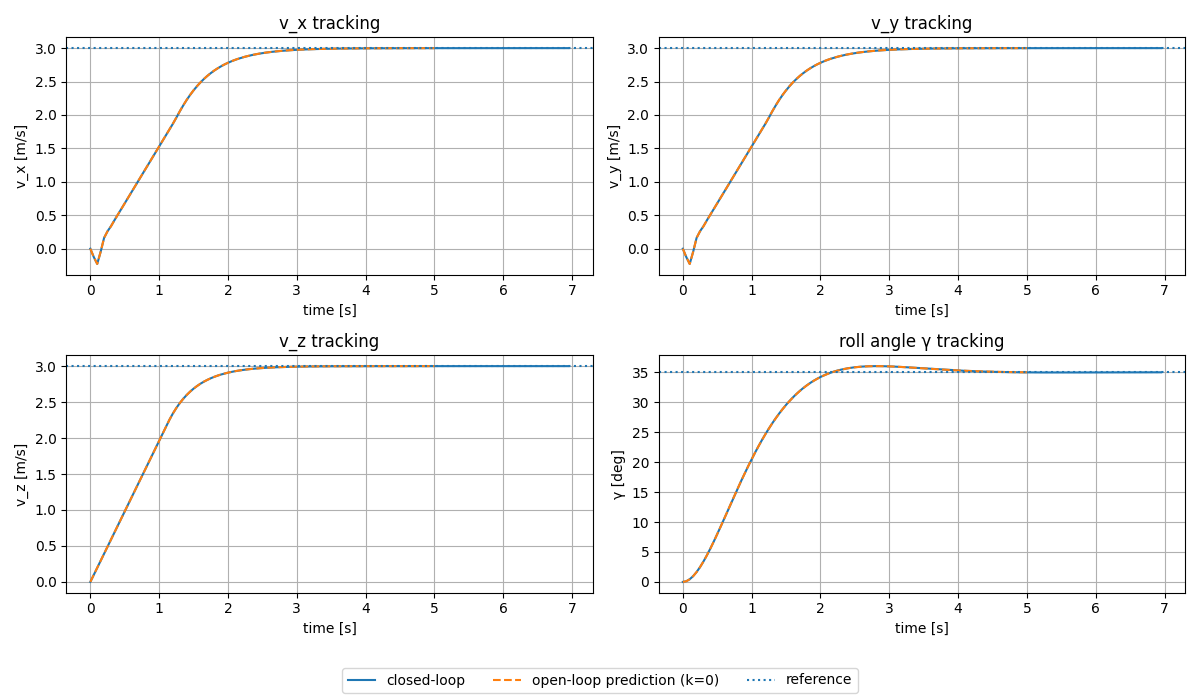

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# After you run simulate_control(...)
# t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, x_target_traj = rocket.simulate_control(...)

k = 0  # prediction made at the first MPC call
t_pred = t_ol[:, k]              # shape (N_ol+1,)
x_pred = x_ol[:, :, k]           # shape (12, N_ol+1)
u_pred = u_ol[:, :, k]           # shape (4, N_ol)

# references (constant)
vx_ref = x_target[6]
vy_ref = x_target[7]
vz_ref = x_target[8]
g_ref  = x_target[5]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

def plot_state(ax, t_cl, x_cl_row, t_pred, x_pred_row, ref, title, ylabel, ref_is_deg=False):
    ax.plot(t_cl[:-1], x_cl_row[:-1], label="closed-loop")
    ax.plot(t_pred, x_pred_row, "--", label="open-loop prediction (k=0)")
    ax.axhline(ref, linestyle=":", label="reference")
    ax.set_title(title)
    ax.set_xlabel("time [s]")
    ax.set_ylabel(ylabel)
    ax.grid(True)

plot_state(axs[0,0], t_cl, x_cl[6,:], t_pred, x_pred[6,:], vx_ref, "v_x tracking", "v_x [m/s]")
plot_state(axs[0,1], t_cl, x_cl[7,:], t_pred, x_pred[7,:], vy_ref, "v_y tracking", "v_y [m/s]")
plot_state(axs[1,0], t_cl, x_cl[8,:], t_pred, x_pred[8,:], vz_ref, "v_z tracking", "v_z [m/s]")

axs[1,1].plot(t_cl[:-1], np.rad2deg(x_cl[5,:-1]), label="closed-loop")
axs[1,1].plot(t_pred, np.rad2deg(x_pred[5,:]), "--", label="open-loop prediction (k=0)")
axs[1,1].axhline(np.rad2deg(g_ref), linestyle=":", label="reference")
axs[1,1].set_title("roll angle γ tracking")
axs[1,1].set_xlabel("time [s]")
axs[1,1].set_ylabel("γ [deg]")
axs[1,1].grid(True)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3)
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

def plot_mpc_trajs(
    t_cl: np.ndarray,          # closed-loop time
    x_cl: np.ndarray,          # closed-loop states (12 x N)
    u_cl: np.ndarray,          # closed-loop inputs (4 x N)
    t_ol: np.ndarray,          # open-loop time grid (N_ol+1 x N_cl)
    x_ol: np.ndarray,          # open-loop predicted states (12 x N_ol+1 x N_cl)
    x_target: np.ndarray,      # reference state (12,)
    xs: np.ndarray,            # trim state
    us: np.ndarray,            # trim input
    k_pred: int = 0             # which MPC prediction to plot
):
    """
    MPC visualization similar to Exercise plot_trajs()
    """

    fig, axs = plt.subplots(2, 2, figsize=(11, 8))

    # ---------------- (1,1) States ----------------
    states = {
        "v_x [m/s]": 6,
        "v_y [m/s]": 7,
        "v_z [m/s]": 8,
        "gamma [deg]": 5
    }

    for label, idx in states.items():
        if idx == 5:
            axs[0, 0].plot(t_cl[:-1], np.rad2deg(x_cl[idx, :-1]), label=label)
            axs[0, 0].plot(
                t_ol[:, k_pred],
                np.rad2deg(x_ol[idx, :, k_pred]),
                "--"
            )
        else:
            axs[0, 0].plot(t_cl[:-1], x_cl[idx, :-1], label=label)
            axs[0, 0].plot(
                t_ol[:, k_pred],
                x_ol[idx, :, k_pred],
                "--"
            )

    axs[0, 0].set_title("States (closed-loop & open-loop prediction)")
    axs[0, 0].legend()
    axs[0, 0].grid()

    # ---------------- (1,2) Output & reference ----------------
    for label, idx in states.items():
        ref = x_target[idx]
        if idx == 5:
            axs[0, 1].plot(t_cl[:-1], np.rad2deg(x_cl[idx, :-1]), label=label)
            axs[0, 1].axhline(np.rad2deg(ref), linestyle="--")
        else:
            axs[0, 1].plot(t_cl[:-1], x_cl[idx, :-1], label=label)
            axs[0, 1].axhline(ref, linestyle="--")

    axs[0, 1].set_title("Tracked outputs & references")
    axs[0, 1].legend()
    axs[0, 1].grid()

    # ---------------- (2,1) Inputs ----------------
    input_labels = ["dR [rad]", "dP [rad]", "Pavg [%]", "Pdiff [%]"]
    for i in range(4):
        axs[1, 0].step(t_cl[:-1], u_cl[i, :], where="post", label=input_labels[i])

    axs[1, 0].set_title("Inputs")
    axs[1, 0].legend()
    axs[1, 0].grid()

    # ---------------- (2,2) Prediction error ----------------
    for label, idx in states.items():
        err = x_ol[idx, :len(t_cl)-1, k_pred] - x_cl[idx, :-1]
        if idx == 5:
            axs[1, 1].plot(t_cl[:-1], np.rad2deg(err), label=label)
        else:
            axs[1, 1].plot(t_cl[:-1], err, label=label)

    axs[1, 1].set_title("Prediction error (open-loop − closed-loop)")
    axs[1, 1].legend()
    axs[1, 1].grid()

    plt.tight_layout()
    plt.show()


ValueError: operands could not be broadcast together with shapes (101,) (140,) 

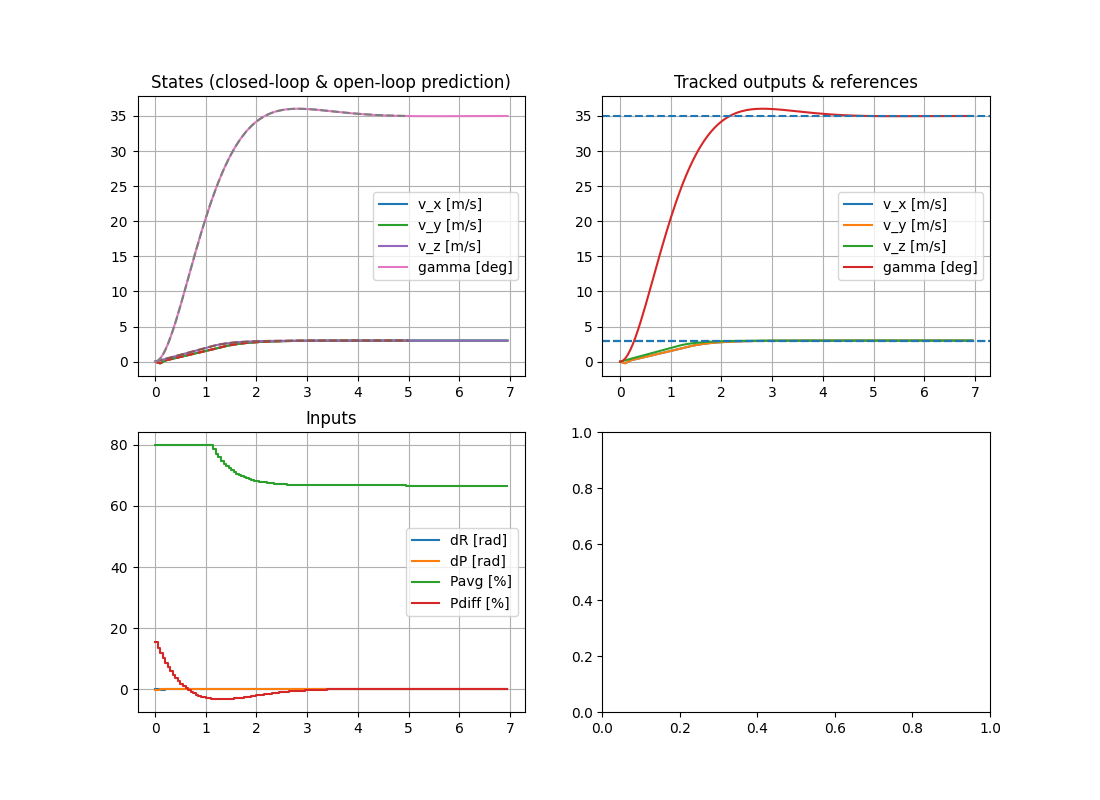

In [6]:
plot_mpc_trajs(
    t_cl=t_cl,
    x_cl=x_cl,
    u_cl=u_cl,
    t_ol=t_ol,
    x_ol=x_ol,
    x_target=x_target,
    xs=xs,
    us=us,
    k_pred=0   # first MPC prediction
)

In [7]:
from plot_style import set_mpc_style
set_mpc_style()

Maximum invariant set successfully computed after 10 iterations.
Maximum invariant set successfully computed after 14 iterations.
Maximum invariant set successfully computed after 8 iterations.
Maximum invariant set successfully computed after 10 iterations.
Maximum invariant set successfully computed after 14 iterations.
Maximum invariant set successfully computed after 8 iterations.
Maximum invariant set successfully computed after 1 iterations.
Maximum invariant set successfully computed after 1 iterations.
Maximum invariant set successfully computed after 1 iterations.
Maximum invariant set successfully computed after 15 iterations.
Maximum invariant set successfully computed after 18 iterations.


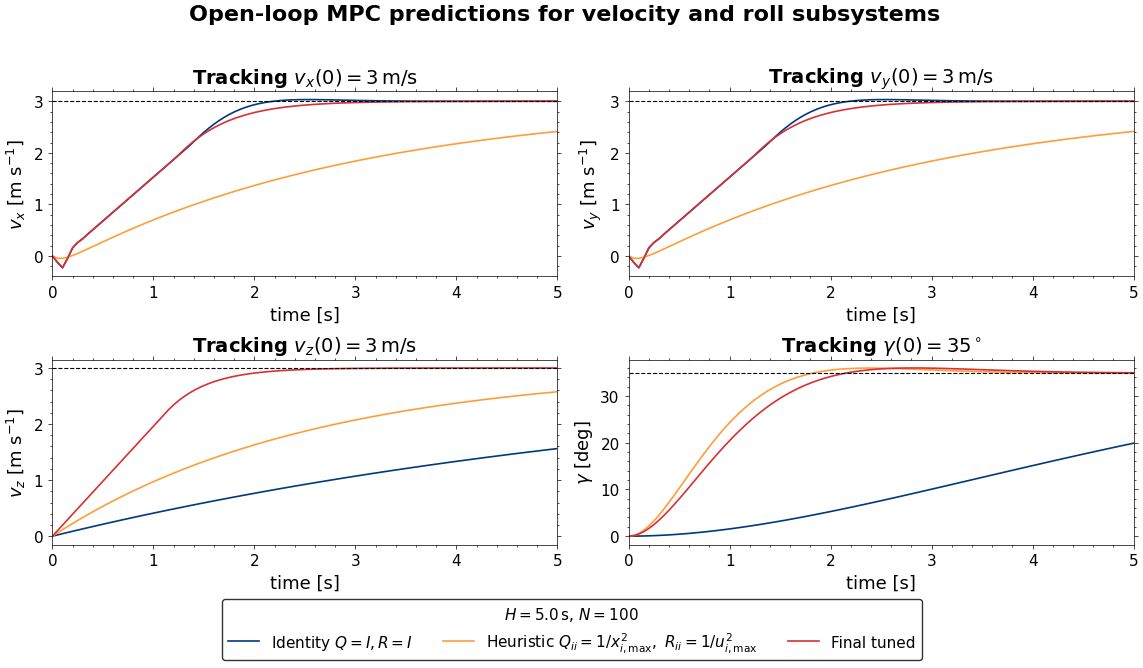

In [10]:
#Open loop plots

import numpy as np
import matplotlib.pyplot as plt

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)   
x0 = xs.copy()  # start at trim (≈ 0 deviation)

# ---------- helper ----------
def run_open_loop(mpc_cls, A, B, xs, us, Ts, H, x0_full,
                  tracked_full_idx, ref_value, y_transform=lambda y: y):

    mpc = mpc_cls(A, B, xs, us, Ts, H)
    x0_sub = x0_full[mpc.x_ids]

    # --- reference is scalar (like your MPCVelControl does) ---
    _, x_ol, _ = mpc.get_u(x0_sub, x_target=ref_value)

    t = np.arange(x_ol.shape[1]) * Ts
    local_idx = list(mpc.x_ids).index(tracked_full_idx)
    y = y_transform(x_ol[local_idx, :])
    return t, y


# ---------- controller sets ----------
ctrl_sets = {
    "Identity $Q=I,R=I$": (
        MPCControl_xvel, MPCControl_yvel,
        MPCControl_zvel, MPCControl_roll
    ),
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": (
        MPCControl_xvel_tuned_default,
        MPCControl_yvel_tuned_default,
        MPCControl_zvel_tuned_default,
        MPCControl_roll_tuned_default
    ),
    "Final tuned": (
        MPCControl_xvel_tuned_final,
        MPCControl_yvel_tuned_final,
        MPCControl_zvel_tuned_final,
        MPCControl_roll_tuned_final
    ),
}

# ---------- figure ----------
fig, axs = plt.subplots(2, 2, figsize=(11.69, 6.8))

fig.suptitle(
    "Open-loop MPC predictions for velocity and roll subsystems",
    fontsize=16,
    fontweight="bold",
    y=0.98
)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11

def format_ax(ax, title, ylabel):
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold")
    ax.set_xlabel(r"time [s]", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.axhline(3.0, linestyle="--", color="k", linewidth=0.8)
    ax.set_xlim(0, H)
    ax.tick_params(labelsize=TICK_FONTSIZE)

# ---------- X velocity ----------
ax = axs[0, 0]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cx, A, B, xs, us, Ts, H,
                         x0, tracked_full_idx=6, ref_value=3.0)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"Tracking $v_x(0)=3\,\mathrm{m/s}$", r"$v_x$ [m s$^{-1}$]")

# ---------- Y velocity ----------
ax = axs[0, 1]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cy, A, B, xs, us, Ts, H,
                         x0, tracked_full_idx=7, ref_value=3.0)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"Tracking $v_y(0)=3\,\mathrm{m/s}$", r"$v_y$ [m s$^{-1}$]")

# ---------- Z velocity ----------
ax = axs[1, 0]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cz, A, B, xs, us, Ts, H,
                         x0, tracked_full_idx=8, ref_value=3.0)
    ax.plot(t, y, label=lbl)
format_ax(ax, r"Tracking $v_z(0)=3\,\mathrm{m/s}$", r"$v_z$ [m s$^{-1}$]")

# ---------- Roll angle ----------
ax = axs[1, 1]
for lbl, (cx, cy, cz, cr) in ctrl_sets.items():
    t, y = run_open_loop(cr, A, B, xs, us, Ts, H,
                         x0, tracked_full_idx=5, ref_value=np.deg2rad(35.0),
                         y_transform=np.rad2deg)
    ax.plot(t, y, label=lbl)
ax.set_title(r"Tracking $\gamma(0)=35^\circ$", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.set_xlabel(r"time [s]", fontsize=LABEL_FONTSIZE)
ax.set_ylabel(r"$\gamma$ [deg]", fontsize=LABEL_FONTSIZE)
ax.axhline(35.0, linestyle="--", color="k", linewidth=0.8)
ax.set_xlim(0, H)
ax.tick_params(labelsize=TICK_FONTSIZE)

# ---------- legend ----------
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=3,
    fontsize=LEGEND_FONTSIZE,
    frameon=True,
    fancybox=True,
    edgecolor="black",
    title=fr"$H={H}\,$s, $N={int(H/Ts)}$",
    title_fontsize=LEGEND_FONTSIZE
)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])

# ---------- save ----------
fig.savefig("openloop_mpc_2x2_a4wide.pdf", bbox_inches="tight")
plt.show()



Maximum invariant set successfully computed after 10 iterations.
Maximum invariant set successfully computed after 10 iterations.
Maximum invariant set successfully computed after 1 iterations.
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
S

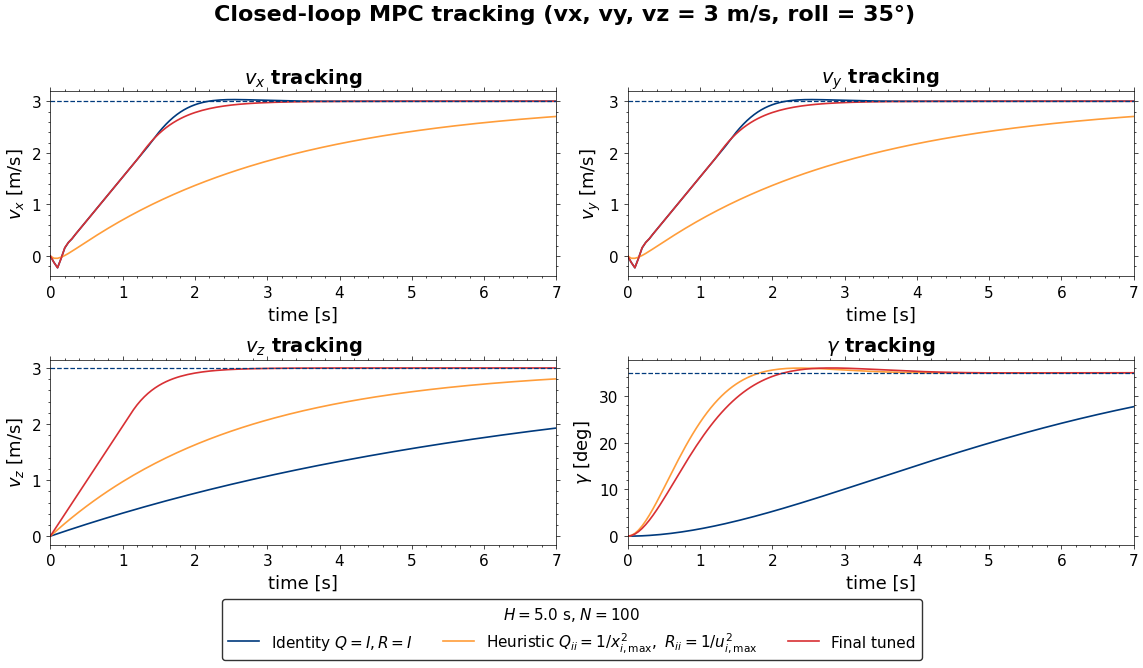

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Setup
# -----------------------------
Ts = 0.05
sim_time = 7
H = 5.0

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()

# Start at trim ("origin")
x0 = xs.copy()

# Constant tracking reference (3 m/s for vx,vy,vz and 35 deg roll)
x_ref = xs.copy()
x_ref[6] = 3.0
x_ref[7] = 3.0
x_ref[8] = 3.0
x_ref[5] = np.deg2rad(35.0)

# -----------------------------
# 1) Make 3 MPCVelControl variants (Identity / Heuristic / Final)
# -----------------------------
from MPCVelControl_D3_2 import MPCVelControl  # your D3.2 file

class MPCVelControl_I(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TD(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_default(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TF(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_final(A, B, self.xs, self.us, Ts, H)
        return self

ctrl_sets_cl = {
    "Identity $Q=I,R=I$": MPCVelControl_I,
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": MPCVelControl_TD,
    "Final tuned": MPCVelControl_TF,
}

# -----------------------------
# 2) Helper: run closed-loop tracking
# -----------------------------
def run_closed_loop_tracking(mpc_full_cls, rocket, Ts, H, sim_time, x0_full, x_ref_full, method="linear"):
    mpc = mpc_full_cls().new_controller(rocket, Ts, H)
    t_cl, x_cl, u_cl, *_ = rocket.simulate_control(
        mpc, sim_time, H, x0_full, method=method, x_target=x_ref_full
    )
    return t_cl, x_cl, u_cl

# -----------------------------
# 3) Plot (2x2)
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(11.69, 6.8))
fig.suptitle("Closed-loop MPC tracking (vx, vy, vz = 3 m/s, roll = 35°)", fontsize=16, fontweight="bold", y=0.98)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11


def format_ax(ax, title, ylabel, ref=None):
    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight="bold")
    ax.set_xlabel("time [s]", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    if ref is not None:
        ax.axhline(ref, linestyle="--", linewidth=0.9)
    ax.set_xlim(0, sim_time)
    #ax.grid(True)
    ax.tick_params(labelsize=TICK_FONTSIZE)

# --- vx ---
ax = axs[0, 0]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, x[6, :], label=lbl)
format_ax(ax, r"$v_x$ tracking", r"$v_x$ [m/s]", ref=3.0)

# --- vy ---
ax = axs[0, 1]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, x[7, :], label=lbl)
format_ax(ax, r"$v_y$ tracking", r"$v_y$ [m/s]", ref=3.0)

# --- vz ---
ax = axs[1, 0]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, x[8, :], label=lbl)
format_ax(ax, r"$v_z$ tracking", r"$v_z$ [m/s]", ref=3.0)

# --- roll gamma ---
ax = axs[1, 1]
for lbl, mpc_cls in ctrl_sets_cl.items():
    t, x, _ = run_closed_loop_tracking(mpc_cls, rocket, Ts, H, sim_time, x0, x_ref)
    ax.plot(t, np.rad2deg(x[5, :]), label=lbl)
format_ax(ax, r"$\gamma$ tracking", r"$\gamma$ [deg]", ref=35.0)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
           title=fr"$H={H}$ s, $N={int(H/Ts)}$", title_fontsize=LEGEND_FONTSIZE)

plt.tight_layout(rect=[0, 0.10, 1, 0.95])
fig.savefig("closedloop_tracking_mpc_2x2_a4wide.pdf", bbox_inches="tight")
plt.show()
